In [160]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [161]:
from matplotlib import pyplot as plt
from matplotlib import colors as colors
import numpy as np

import sys 
#sys.path.append('../')

from importlib import reload
import Utils.utils as util
reload(util)


from sklearn.linear_model import Lasso
from sklearn.multiclass import OneVsRestClassifier
from sklearn.preprocessing import normalize

np.set_printoptions(threshold=np.inf) #print full arrays
from sklearn import linear_model


In [162]:
def split_patch(patch):
    h = patch.shape[0]
    #Convert one patch into a column vector for training
    patch = patch.flatten()
    pixel_central = patch[(h*(h//2)+(h//2))*3:(h*(h//2)+(h//2))*3+3]
    patch_sans_central = np.delete(patch, range((h*(h//2)+(h//2))*3, (h*(h//2)+(h//2))*3+3))
    return np.array((patch_sans_central, pixel_central))
    
def convert_patch_into_vector(patch):
    #Convert one patch into a column vector for training
    #patch = patch.flatten()
    h = patch.shape[0]
    patch = np.reshape(patch, h*h*3)
    return np.array(patch)

def convert_vector_into_patch(vector, h):
    #Convert a one column vector into a patch of size h
    return vector.reshape((h,h,7))
    
def convert_patches_into_training_set(patches):
    #Convert a set of patches into a set of vectors
    return np.array(list(map(convert_patch_into_vector, patches))).T

def find_index_noisy_lines(label):
    """
    indexes = []
    for index, value in enumerate(label):
        if(value == -1):
            indexes.append(index)
    """
    label = np.array(label)
    indexes = np.where(label < 0)
    return indexes

def delete_all_indexes_from(dictionary, label):
    indexes = find_index_noisy_lines(label)
    dictionary = np.delete(dictionary, indexes , axis=0)
    label = np.delete(label, indexes , axis=0)
    
    return (dictionary, label)    

#test the alpha on a lot of cleared patches and returns an average value
def estimate_alpha(noisy_image, dictionary_full, h):
    lassocv = linear_model.LassoCV()
    listalpha = []
    width = noisy_image.shape[1]
    height = noisy_image.shape[0]
    #params
    pas = h+10
    start = h//2
    endx = height-h//2
    endy = width-h//2
    #end params
    i=0
    total = int( (endx-pas)/pas * (endy-pas)/pas )
    for x in range(start,endx,pas):
        for y in range(start,endy,pas):
            label = util.get_patch(x, y, h, noisy_image)
            label = list(convert_patch_into_vector(label))
            dictionary, label = delete_all_indexes_from(dictionary_full,label)
            lassocv.fit(dictionary_full, label)
            alpha_ = lassocv.alpha_
            listalpha.append(alpha_)
            i+=1
            if(i%10==0): print(i, "/", total)
    return np.mean(np.array(listalpha))
    
def removearray(L,arr):
    ind = 0
    size = len(L)
    while ind != size and not np.array_equal(L[ind],arr):
        ind += 1
    if ind != size:
        L.pop(ind)
    else:
        #raise ValueError('array not found in list.') #todo, why am I getting this one in optimized mode
        print('ERROR:  removearray(L,arr): array not found in list.')

def inpaint_image(noisy_image, dictionary, coord_noisy_pix, h, clear_image):
    noisy_image_orig = np.array(noisy_image)
    dictionary_full = np.copy(dictionary)
    
    width  = noisy_image.shape[1]
    height = noisy_image.shape[0]
    
    #todo question: vérifier qu'il faut bien faire le lassocv pour trouver le alpha sur le clear?
    lassocv = linear_model.LassoCV(max_iter=20000)  #1000 by default, 100 works OK most of the time
    """
    y, x = coord_noisy_pix[0]
    label = util.get_patch(x, y, h, noisy_image)
    #label = util.get_patch(x, y, h, clear_image)
    label = list(convert_patch_into_vector(label))
    lassocv.fit(dictionary_full, label)
    alpha_ = lassocv.alpha_
    """
    #alpha_ = estimate_alpha(noisy_image, dictionary_full, h)
    #autre idée: en prendre 10 aléatoirement ?
    alpha_ = 0.01 #default value
    
    print("alpha = ", alpha_)
       
    i = 0
    nbcorrections = 0
    nbiter  = int(len(coord_noisy_pix))
    while i < nbiter: # DONT USE FOR FOR THIS BECAUSE WE WILL MODIFY THE LIST
        
        x, y  = coord_noisy_pix[i] 
        #print(noisy_image[x][y])
        #print(noisy_image[x][y] == -1)
        #utile pour la correction des carrés manquants
        while( not(np.all(noisy_image[x][y] == -1 )) and i+1 < nbiter): #zap si rien à corriger
            print("PIXEL ",x,y," DEJA CORRIGE")
            i=i+1
            x, y  = coord_noisy_pix[i]
            #print(noisy_image[x][y])
        if(i+1 >= nbiter): pass
        
        #print("Correction de : (", x, ", ", y,")")
        patch = util.get_patch2(x, y, h, noisy_image)

        #util.display_im(patch)
        labelfull = list(convert_patch_into_vector(patch))
        
        #print("labelfull : ", labelfull)
        
        dictionary = np.copy(dictionary_full)
        dictionary, label = delete_all_indexes_from(dictionary, labelfull)

        #print("--- lasso regression ---")
        
        #recalcule du alpha à chaque patch
        lassocv.fit(dictionary, label)
        alpha_ = lassocv.alpha_
        print("alpha = ", alpha_)
        #fin recalcule du alpha
        
        model = Lasso(fit_intercept=True, alpha=alpha_, positive=True)
        model.fit(dictionary, label)
        
        #################################################
        #version somme cumulée pondérée
        res = model.predict(dictionary_full)
        
        #version argmax
        #print("argmax = ",np.argmax(model.coef_)," / ", model.coef_.shape)
        #res = dictionary_full.T[np.argmax(model.coef_)]
        #################################################
        
        #avec le predict on peut avoir des valeurs >255 ou <0 donc on corrige
        
        res = np.array(res.astype(int))
        if(len(np.where(res > 255)[0]) > 0 or len(np.where(res < 0)[0]) > 0):
            res[res > 255] = 255
            res[res < 0] = 0
        
            
        #util.display_im(patch)
        #util.display_im(res.reshape(h,h,3))
        #################################################
        #coef = model.coef_.reshape((1,-1)) #poids
        #print("nb patch not at zero: ", np.count_nonzero(model.sparse_coef_.toarray()), " / ", coef.shape[1])
       
        # corrige juste le pixel central
        #"""
        # and use y, x = coord_noisy_pix[i]  at the beginning of the while
        #util.display_im(res.reshape(h,h,3))
        newPixel = util.get_centered_pixel(res, h)
        #util.display_im([[[newPixel]]])
        print("new pixel (lasso): ", newPixel)
        noisy_image[x][y] = newPixel
        if(i%10==0): print( i, " / ",  nbiter)
        i=i+1
        #"""
        
        """
        # corrige tous les pixels noirs dans le patch
        labelfull = np.array(labelfull)
        list_indexes_noise = np.where(labelfull == -1)[0] 
        #print(patch)
        #print("pixels at -1:",np.where(labelfull == -1))
        #print(np.where(labelfull == -1))   
        indexeach3 = list(range(0,len(list_indexes_noise),3))
        listindexes2 = list_indexes_noise[indexeach3] #on prend que 1 sur 3 car 3 valeurs par pixel
        xpatch = x-h//2
        ypatch = y-h//2
        i=i+1       
        for val in listindexes2:
            val = (val//3)
            ylocal = int((val)//h)
            xlocal = int(val-ylocal*h)            
            #print("xpatch = ",xpatch," ypatch=",ypatch)
            #print("xlocal = ",xlocal," ylocal=",ylocal)
            xglobal = xpatch + ylocal  #vérifié
            yglobal = ypatch + xlocal  #vérifié
            print("correcting pixel (",xglobal,",",yglobal,")")
            #print("xglobal=",xglobal," yglobal=",yglobal)
            res = res.reshape(h,h,3)
            newpixel = res[ylocal, xlocal] #vérifié!
            #print("correction; ",newpixel)
            #because of getpatch2 we need to test if we are in the img or outside
            if(xglobal >= 0 and yglobal >= 0 and xglobal < height and yglobal < width):
                noisy_image[xglobal][yglobal] = newpixel
                nbcorrections += 1
            if(nbcorrections%10==0): print("*** avancement : ", nbcorrections, " / ",  nbiter)
            ##########################
            ##supprimer de la liste pour pas le refaire #obsolète on ne fait plus ça
            #coord_noisy_pix = list( coord_noisy_pix)
            #currentpixel = [xglobal, yglobal] #ok vérifié
            ##print("remove : ", currentpixel)
            #removearray(coord_noisy_pix, np.array(currentpixel))
            #coord_noisy_pix = list( coord_noisy_pix)
            ##print("left to correct : ",len(coord_noisy_pix))
            #i = i + 1
            #if(i%10==0):
            #    print( i, " / ",  nbiter)
            ##########################
        #util.display_im(util.get_patch2(x, y, h, noisy_image).reshape(h,h,3))
        #util.display_im(noisy_image)
    
       #"""    
        #################################################
        
        #Test  -> reconstruire de nouveaux patch à partir des pixels corrigés ?
        #_,clear_patches = util.get_patches(noisy_image, h, width, height)
        #dictionary_full = convert_patches_into_training_set(clear_patches)
        #print("shape : ", dictionary_full.shape)

    util.display_im(noisy_image_orig)
    util.display_im(noisy_image)

taille de l'image :  (100, 100, 3)
nb pixels à corriger:  499
nbclear pacthes: 700


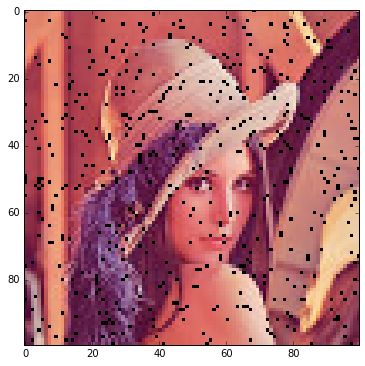

In [163]:
%matplotlib inline
img_matrice = util.read_im("Data/imgdataset/lennasmall.jpg")
#lennasmall.jpg

print("taille de l'image : ", img_matrice.shape)

#util.display_im(img_matrice)

#Taille des patchs
h=3 #nombre impair !!

width = img_matrice.shape[1]
height = img_matrice.shape[0]
noisy_image, deletepixels = util.noise2(img_matrice, 0.05, width, height, h);
#noisy_image, deletepixels = util.delete_rect(img_matrice,  63, 51, 13, 75) #10small

#10small 63, 51, 13, 75
#12.jpg 85, 75, 30, 6

print("nb pixels à corriger: ", np.array(deletepixels).shape[0])

width = img_matrice.shape[1]
height = img_matrice.shape[0]

#print(width," , ", height)

util.display_im(noisy_image)

_,clear_patches = util.get_patches(noisy_image, h, width, height)

nbclear = np.shape(clear_patches)[0]
print("nbclear pacthes:", nbclear)

(27, 700)


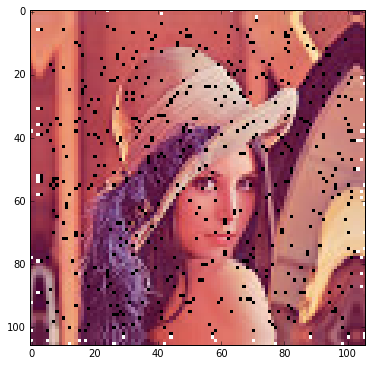

In [164]:
training = convert_patches_into_training_set(clear_patches)
print(training.shape)

#test de l'extension d'image
newimg = util.extend_image(noisy_image, h)
util.display_im(newimg)

In [165]:
a = np.array([[1, 'a'], [2, 'a'], [3, 'a'], [4, 'a'], [5, 'a'], [6, 'a'], [7, 'a'], [8, 'a'], [9, 'a']])
#print(a.shape)    
a = a.reshape(3,3,2)
#print(a.shape)
#print("center=",util.get_centered_pixel(a, 3))

#coefsize = (1, 2510)   dicofullsize = (27, 2510)  ressize= (27, 2510)
coef = np.array([0,1,2])
coef = coef.reshape(-1,1)
#print(coef.shape)
dico = [1,2,3]
coef.T*dico

#util.spyral_transformation(a)

array([[0, 2, 6]])

1  2  3  4
5  6  7  8
9 10 11 12

In [ ]:
deletepixels_transformed = util.spyral_transformation(np.array(deletepixels))

inpaint_image(noisy_image, training, deletepixels_transformed, h, img_matrice)

spyral_transformation(a): tab is not of 3 dimensions, doing nothing
alpha =  0.01
alpha =  114.961334408
new pixel (lasso):  [195  91  96]
0  /  499
alpha =  1.55177324263
new pixel (lasso):  [91 19 60]


/usr/lib/python3/dist-packages/sklearn/linear_model/coordinate_descent.py:466: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations
  ConvergenceWarning)


alpha =  11.9337594345
new pixel (lasso):  [236 140 112]


/usr/lib/python3/dist-packages/sklearn/linear_model/coordinate_descent.py:466: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations
  ConvergenceWarning)


alpha =  381.508468952
new pixel (lasso):  [73 35 51]
alpha =  97.6182588581
new pixel (lasso):  [112  31  79]
alpha =  2.93152083333
new pixel (lasso):  [175  67  81]


/usr/lib/python3/dist-packages/sklearn/linear_model/coordinate_descent.py:466: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations
  ConvergenceWarning)


alpha =  102.314790083
new pixel (lasso):  [106  44  83]
alpha =  2.78013777778
new pixel (lasso):  [169  65  80]


/usr/lib/python3/dist-packages/sklearn/linear_model/coordinate_descent.py:466: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations
  ConvergenceWarning)


alpha =  3.00525786341
new pixel (lasso):  [232 141 132]


/usr/lib/python3/dist-packages/sklearn/linear_model/coordinate_descent.py:466: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations
  ConvergenceWarning)


alpha =  85.7621480701
new pixel (lasso):  [187  94  95]
alpha =  115.585554266
new pixel (lasso):  [167  99 130]
10  /  499
alpha =  307.590702948
new pixel (lasso):  [195 126 117]
alpha =  59.7296833789
new pixel (lasso):  [160  57  69]
alpha =  18.2580317442
new pixel (lasso):  [219 157 163]
alpha =  3.12771875
new pixel (lasso):  [226 124 113]


/usr/lib/python3/dist-packages/sklearn/linear_model/coordinate_descent.py:466: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations
  ConvergenceWarning)


alpha =  18.0977704661
new pixel (lasso):  [90 24 68]
alpha =  8.57076111103
new pixel (lasso):  [108  31  72]
alpha =  4.44928013966
new pixel (lasso):  [139  43  63]


/usr/lib/python3/dist-packages/sklearn/linear_model/coordinate_descent.py:466: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations
  ConvergenceWarning)


alpha =  29.0248967507
new pixel (lasso):  [156  67  82]


/usr/lib/python3/dist-packages/sklearn/linear_model/coordinate_descent.py:466: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations
  ConvergenceWarning)


alpha =  2.91998412698
new pixel (lasso):  [172  65  75]


/usr/lib/python3/dist-packages/sklearn/linear_model/coordinate_descent.py:466: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations
  ConvergenceWarning)


alpha =  3.30527083333
new pixel (lasso):  [206  92  93]
20  /  499


/usr/lib/python3/dist-packages/sklearn/linear_model/coordinate_descent.py:466: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations
  ConvergenceWarning)


alpha =  3.80777608758
new pixel (lasso):  [92 35 73]


/usr/lib/python3/dist-packages/sklearn/linear_model/coordinate_descent.py:466: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations
  ConvergenceWarning)


alpha =  17.105056074
new pixel (lasso):  [94 36 77]
alpha =  92.5786880214
new pixel (lasso):  [208 139 127]
alpha =  119.105104939
new pixel (lasso):  [82 26 65]
alpha =  1.30905208333
new pixel (lasso):  [101  34  87]
alpha =  145.936585425
new pixel (lasso):  [235 189 177]
alpha =  79.4027189984
new pixel (lasso):  [133  80 135]
alpha =  171.634544378
new pixel (lasso):  [228 147 128]
alpha =  3.19190625
new pixel (lasso):  [200  91  89]


/usr/lib/python3/dist-packages/sklearn/linear_model/coordinate_descent.py:466: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations
  ConvergenceWarning)


alpha =  42.5185140322
new pixel (lasso):  [89 26 61]
30  /  499
alpha =  20.090952381
new pixel (lasso):  [199 128 135]
alpha =  45.2058762227
new pixel (lasso):  [175  73  82]
alpha =  20.0518057585
new pixel (lasso):  [210 151 125]
alpha =  49.829680121
new pixel (lasso):  [203 104 107]
alpha =  3.02213758998
new pixel (lasso):  [86 11 53]
alpha =  15.2817059864
new pixel (lasso):  [228 111 107]
alpha =  2.936828125
new pixel (lasso):  [184  96 115]
alpha =  77.8510181966
new pixel (lasso):  [194 121 126]
alpha =  198.991722302
new pixel (lasso):  [254 170 149]
alpha =  673.553800632
new pixel (lasso):  [125  82  86]
40  /  499
alpha =  3.15750557907
new pixel (lasso):  [236 185 164]
alpha =  3.12739229025
new pixel (lasso):  [161 100 117]
alpha =  60.4571769286
new pixel (lasso):  [214 134 152]
alpha =  21.5749134809
new pixel (lasso):  [195  79  80]


/usr/lib/python3/dist-packages/sklearn/linear_model/coordinate_descent.py:466: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations
  ConvergenceWarning)


alpha =  282.153320117
new pixel (lasso):  [99 41 68]
alpha =  6.62844592051
new pixel (lasso):  [101  25  65]


/usr/lib/python3/dist-packages/sklearn/linear_model/coordinate_descent.py:466: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations
  ConvergenceWarning)


alpha =  2.87847619048
new pixel (lasso):  [169  62  76]


/usr/lib/python3/dist-packages/sklearn/linear_model/coordinate_descent.py:466: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations
  ConvergenceWarning)


alpha =  2.77380952381
new pixel (lasso):  [161  58  71]


/usr/lib/python3/dist-packages/sklearn/linear_model/coordinate_descent.py:466: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations
  ConvergenceWarning)


alpha =  5.61905670942
new pixel (lasso):  [179  69  80]
alpha =  16.5480549396
new pixel (lasso):  [156  59  77]
50  /  499


/usr/lib/python3/dist-packages/sklearn/linear_model/coordinate_descent.py:466: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations
  ConvergenceWarning)


alpha =  78.4408755603
new pixel (lasso):  [205 128 117]
alpha =  41.3514161475
new pixel (lasso):  [143 103 142]
alpha =  11.2287487262
new pixel (lasso):  [205 138 128]


/usr/lib/python3/dist-packages/sklearn/linear_model/coordinate_descent.py:466: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations
  ConvergenceWarning)


alpha =  49.5604816012
new pixel (lasso):  [201 130 126]


/usr/lib/python3/dist-packages/sklearn/linear_model/coordinate_descent.py:466: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations
  ConvergenceWarning)


alpha =  57.4235956572
new pixel (lasso):  [229 171 164]
alpha =  68.1935425196
new pixel (lasso):  [173  91 110]
alpha =  5.0139532607
new pixel (lasso):  [156 102 142]
alpha =  3.82899723502
new pixel (lasso):  [191  78  84]


/usr/lib/python3/dist-packages/sklearn/linear_model/coordinate_descent.py:466: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations
  ConvergenceWarning)


alpha =  67.6289751184
new pixel (lasso):  [203 130 114]
alpha =  5.94229614033
new pixel (lasso):  [171  65  79]
60  /  499


/usr/lib/python3/dist-packages/sklearn/linear_model/coordinate_descent.py:466: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations
  ConvergenceWarning)


alpha =  105.912409347
new pixel (lasso):  [214 151 124]
alpha =  2.28225
new pixel (lasso):  [136  41  62]
alpha =  177.531091912
new pixel (lasso):  [211 114 104]
alpha =  133.885496706
new pixel (lasso):  [151  74  84]
alpha =  5.21838577788
new pixel (lasso):  [206  96  92]


/usr/lib/python3/dist-packages/sklearn/linear_model/coordinate_descent.py:466: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations
  ConvergenceWarning)


alpha =  30.8573281997
new pixel (lasso):  [211 101  99]


/usr/lib/python3/dist-packages/sklearn/linear_model/coordinate_descent.py:466: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations
  ConvergenceWarning)


alpha =  0.9619375
new pixel (lasso):  [219 190 180]
alpha =  7.33358112333
new pixel (lasso):  [201 136 124]
alpha =  18.3645574035
new pixel (lasso):  [200 105 104]


/usr/lib/python3/dist-packages/sklearn/linear_model/coordinate_descent.py:466: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations
  ConvergenceWarning)


alpha =  22.3062298166
new pixel (lasso):  [210 129 142]
70  /  499
alpha =  32.094490785
new pixel (lasso):  [203 171 165]
alpha =  7.95113711616
new pixel (lasso):  [174  59  71]


/usr/lib/python3/dist-packages/sklearn/linear_model/coordinate_descent.py:466: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations
  ConvergenceWarning)


alpha =  3.39996701389
new pixel (lasso):  [196  85  91]
alpha =  2.83277604167
new pixel (lasso):  [193  92  98]


/usr/lib/python3/dist-packages/sklearn/linear_model/coordinate_descent.py:466: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations
  ConvergenceWarning)


alpha =  8.81347539441
new pixel (lasso):  [225 173 171]
alpha =  2.659375
new pixel (lasso):  [173  82 102]
alpha =  27.8352148648
new pixel (lasso):  [92 21 60]
alpha =  224.10166042
new pixel (lasso):  [199 103 108]
alpha =  3.31588963046
new pixel (lasso):  [208 155 150]
alpha =  3.47769113326
new pixel (lasso):  [155  64  82]
80  /  499


/usr/lib/python3/dist-packages/sklearn/linear_model/coordinate_descent.py:466: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations
  ConvergenceWarning)


alpha =  2.54992591694
new pixel (lasso):  [111  33  72]
alpha =  50.1056614736
new pixel (lasso):  [235 193 181]
alpha =  17.079341936
new pixel (lasso):  [222 184 171]
alpha =  4.40667702959
new pixel (lasso):  [203 130 120]


/usr/lib/python3/dist-packages/sklearn/linear_model/coordinate_descent.py:466: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations
  ConvergenceWarning)


alpha =  2.068984375
new pixel (lasso):  [197 131 118]


/usr/lib/python3/dist-packages/sklearn/linear_model/coordinate_descent.py:466: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations
  ConvergenceWarning)


alpha =  28.0766755896
new pixel (lasso):  [195  87  81]
alpha =  43.521332056
new pixel (lasso):  [196  84  86]


/usr/lib/python3/dist-packages/sklearn/linear_model/coordinate_descent.py:466: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations
  ConvergenceWarning)


alpha =  3.10920634921
new pixel (lasso):  [203  96  94]


/usr/lib/python3/dist-packages/sklearn/linear_model/coordinate_descent.py:466: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations
  ConvergenceWarning)


alpha =  4.73307204252
new pixel (lasso):  [210 100 105]


/usr/lib/python3/dist-packages/sklearn/linear_model/coordinate_descent.py:466: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations
  ConvergenceWarning)


alpha =  20.6843864249
new pixel (lasso):  [170  71  96]
90  /  499
alpha =  99.8772986125
new pixel (lasso):  [96 28 56]
alpha =  15.3827025793
new pixel (lasso):  [80 18 67]
alpha =  4.64358343408
new pixel (lasso):  [144  48  67]


/usr/lib/python3/dist-packages/sklearn/linear_model/coordinate_descent.py:466: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations
  ConvergenceWarning)


alpha =  367.305652424
new pixel (lasso):  [102  65  95]
alpha =  2.93713580247
new pixel (lasso):  [220 129 112]


/usr/lib/python3/dist-packages/sklearn/linear_model/coordinate_descent.py:466: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations
  ConvergenceWarning)


alpha =  7.91780241504
new pixel (lasso):  [125  73 129]
alpha =  2.78840075894
new pixel (lasso):  [228 166 145]
alpha =  75.5038267012
new pixel (lasso):  [164  94 100]
alpha =  6.45325794959
new pixel (lasso):  [210 143 129]


/usr/lib/python3/dist-packages/sklearn/linear_model/coordinate_descent.py:466: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations
  ConvergenceWarning)


alpha =  151.040515156
new pixel (lasso):  [127  43  77]
100  /  499
alpha =  3.12566666667
new pixel (lasso):  [233 139 112]


/usr/lib/python3/dist-packages/sklearn/linear_model/coordinate_descent.py:466: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations
  ConvergenceWarning)


alpha =  0.9656875
new pixel (lasso):  [104  51 100]
alpha =  34.4995964273
new pixel (lasso):  [170  65  76]


/usr/lib/python3/dist-packages/sklearn/linear_model/coordinate_descent.py:466: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations
  ConvergenceWarning)


alpha =  3.28168543085
new pixel (lasso):  [196  91  97]


/usr/lib/python3/dist-packages/sklearn/linear_model/coordinate_descent.py:466: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations
  ConvergenceWarning)


alpha =  2.2399478458
new pixel (lasso):  [209 136 127]


/usr/lib/python3/dist-packages/sklearn/linear_model/coordinate_descent.py:466: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations
  ConvergenceWarning)


alpha =  3.05059375
new pixel (lasso):  [189  82  86]


/usr/lib/python3/dist-packages/sklearn/linear_model/coordinate_descent.py:466: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations
  ConvergenceWarning)


alpha =  3.19993579618
new pixel (lasso):  [215 115 107]


/usr/lib/python3/dist-packages/sklearn/linear_model/coordinate_descent.py:466: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations
  ConvergenceWarning)


alpha =  86.3800526721
new pixel (lasso):  [189  93  96]


/usr/lib/python3/dist-packages/sklearn/linear_model/coordinate_descent.py:466: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations
  ConvergenceWarning)


alpha =  1348.20486111
new pixel (lasso):  [112 112 112]
alpha =  30.6621174202
new pixel (lasso):  [137  62  91]
110  /  499
alpha =  108.685584005
new pixel (lasso):  [165  63  81]
alpha =  173.561584432
new pixel (lasso):  [170 111 106]
alpha =  5.81072306594
new pixel (lasso):  [206  93  86]


/usr/lib/python3/dist-packages/sklearn/linear_model/coordinate_descent.py:466: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations
  ConvergenceWarning)


alpha =  619.387477915
new pixel (lasso):  [114  90 103]
alpha =  924.64446073
new pixel (lasso):  [207 176 177]
alpha =  1087.71099395
new pixel (lasso):  [161 106 114]
alpha =  3.95697538593
new pixel (lasso):  [207 139 127]


/usr/lib/python3/dist-packages/sklearn/linear_model/coordinate_descent.py:466: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations
  ConvergenceWarning)


alpha =  28.9660954374
new pixel (lasso):  [222 131 128]


/usr/lib/python3/dist-packages/sklearn/linear_model/coordinate_descent.py:466: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations
  ConvergenceWarning)


alpha =  2.88853559973
new pixel (lasso):  [144  69  88]


/usr/lib/python3/dist-packages/sklearn/linear_model/coordinate_descent.py:466: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations
  ConvergenceWarning)


alpha =  85.594745245
new pixel (lasso):  [191 119 120]
120  /  499
alpha =  41.2805118434
new pixel (lasso):  [212 114 111]
alpha =  12.2948622178
new pixel (lasso):  [198  86  92]


/usr/lib/python3/dist-packages/sklearn/linear_model/coordinate_descent.py:466: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations
  ConvergenceWarning)


alpha =  218.336380331
new pixel (lasso):  [84 36 62]
alpha =  3.95758431545
new pixel (lasso):  [234 185 160]
alpha =  73.4259812418
new pixel (lasso):  [188  92 107]
alpha =  10.8185669317
new pixel (lasso):  [184  67  81]


/usr/lib/python3/dist-packages/sklearn/linear_model/coordinate_descent.py:466: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations
  ConvergenceWarning)


alpha =  179.922792686
new pixel (lasso):  [106  48  67]
alpha =  18.2336059824
new pixel (lasso):  [155  54  67]


/usr/lib/python3/dist-packages/sklearn/linear_model/coordinate_descent.py:466: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations
  ConvergenceWarning)


alpha =  1.64603854875
new pixel (lasso):  [100  24  64]


/usr/lib/python3/dist-packages/sklearn/linear_model/coordinate_descent.py:466: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations
  ConvergenceWarning)


alpha =  49.1408442071
new pixel (lasso):  [132  56  89]
130  /  499
alpha =  117.189128174
new pixel (lasso):  [88 27 57]
alpha =  39.4046171971
new pixel (lasso):  [221 167 153]
alpha =  69.2969790104
new pixel (lasso):  [157 111 142]
alpha =  3.25360770975
new pixel (lasso):  [208  97  95]


/usr/lib/python3/dist-packages/sklearn/linear_model/coordinate_descent.py:466: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations
  ConvergenceWarning)


alpha =  8.24411449383
new pixel (lasso):  [221 128 114]


/usr/lib/python3/dist-packages/sklearn/linear_model/coordinate_descent.py:466: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations
  ConvergenceWarning)


alpha =  2.165265625
new pixel (lasso):  [222 160 133]
alpha =  30.7613821365
new pixel (lasso):  [223 114 107]


/usr/lib/python3/dist-packages/sklearn/linear_model/coordinate_descent.py:466: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations
  ConvergenceWarning)


alpha =  14.6494499483
new pixel (lasso):  [237 190 174]
alpha =  43.8821509893
new pixel (lasso):  [215 165 159]
alpha =  136.858677568
new pixel (lasso):  [225 171 140]
140  /  499
alpha =  1.88878645833
new pixel (lasso):  [193 130 125]


/usr/lib/python3/dist-packages/sklearn/linear_model/coordinate_descent.py:466: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations
  ConvergenceWarning)


alpha =  12.0282516664
new pixel (lasso):  [96 36 80]
alpha =  2.78773777778
new pixel (lasso):  [169  65  80]


/usr/lib/python3/dist-packages/sklearn/linear_model/coordinate_descent.py:466: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations
  ConvergenceWarning)


alpha =  88.7915570839
new pixel (lasso):  [142  80 132]
alpha =  6.18731397301
new pixel (lasso):  [141  58  78]


/usr/lib/python3/dist-packages/sklearn/linear_model/coordinate_descent.py:466: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations
  ConvergenceWarning)


alpha =  2.24448958333
new pixel (lasso):  [208 136 127]


/usr/lib/python3/dist-packages/sklearn/linear_model/coordinate_descent.py:466: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations
  ConvergenceWarning)


alpha =  30.3316750439
new pixel (lasso):  [119  46  67]
alpha =  14.0792113075
new pixel (lasso):  [228 177 173]
alpha =  45.6691708497
new pixel (lasso):  [98 24 55]
alpha =  131.786109365
new pixel (lasso):  [98 47 77]
150  /  499
alpha =  1.89397916667
new pixel (lasso):  [225 160 147]
alpha =  7.26207600955
new pixel (lasso):  [227 131 134]
alpha =  47.2566669264
new pixel (lasso):  [102  28  60]
alpha =  67.2234628545
new pixel (lasso):  [210 134 132]
alpha =  17.7399614352
new pixel (lasso):  [172 104 149]
alpha =  196.688505891
new pixel (lasso):  [136  61  82]
alpha =  34.3882736015
new pixel (lasso):  [183  80  86]


/usr/lib/python3/dist-packages/sklearn/linear_model/coordinate_descent.py:466: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations
  ConvergenceWarning)


alpha =  87.7074999034
new pixel (lasso):  [163  69  75]
alpha =  3.10772395833
new pixel (lasso):  [207 101  97]


/usr/lib/python3/dist-packages/sklearn/linear_model/coordinate_descent.py:466: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations
  ConvergenceWarning)


alpha =  104.85625
new pixel (lasso):  [221 191 184]
160  /  499
alpha =  3.01975694444
new pixel (lasso):  [150  73 105]
alpha =  27.9253781436
new pixel (lasso):  [92 25 52]
alpha =  39.0537388847
new pixel (lasso):  [225 197 187]


/usr/lib/python3/dist-packages/sklearn/linear_model/coordinate_descent.py:466: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations
  ConvergenceWarning)


alpha =  99.0109101745
new pixel (lasso):  [140  89 129]
alpha =  1.84591156463
new pixel (lasso):  [110  42  85]
alpha =  11.2616052375
new pixel (lasso):  [220 111 105]


/usr/lib/python3/dist-packages/sklearn/linear_model/coordinate_descent.py:466: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations
  ConvergenceWarning)


alpha =  6.49169056486
new pixel (lasso):  [94 26 65]
alpha =  5.49755141393
new pixel (lasso):  [203  93  93]


/usr/lib/python3/dist-packages/sklearn/linear_model/coordinate_descent.py:466: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations
  ConvergenceWarning)


alpha =  38.9475636887
new pixel (lasso):  [210 105 102]
alpha =  2.74784807256
new pixel (lasso):  [170  66  79]
170  /  499


/usr/lib/python3/dist-packages/sklearn/linear_model/coordinate_descent.py:466: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations
  ConvergenceWarning)


alpha =  62.0566841148
new pixel (lasso):  [208 115 118]
alpha =  1349.83468461
new pixel (lasso):  [166 127 122]
alpha =  1.68083333333
new pixel (lasso):  [121  47  86]
alpha =  2.7161292517
new pixel (lasso):  [172  74  90]


/usr/lib/python3/dist-packages/sklearn/linear_model/coordinate_descent.py:466: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations
  ConvergenceWarning)


alpha =  34.2950520833
new pixel (lasso):  [216 102  95]
alpha =  61.2837501555
new pixel (lasso):  [85 28 65]
alpha =  12.0122079313
new pixel (lasso):  [182  72  78]


/usr/lib/python3/dist-packages/sklearn/linear_model/coordinate_descent.py:466: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations
  ConvergenceWarning)


alpha =  10.804169614
new pixel (lasso):  [220 126 116]


/usr/lib/python3/dist-packages/sklearn/linear_model/coordinate_descent.py:466: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations
  ConvergenceWarning)


alpha =  129.904715568
new pixel (lasso):  [165 106 146]
alpha =  73.3136308624
new pixel (lasso):  [89 23 59]
180  /  499
alpha =  3.3253877551
new pixel (lasso):  [215 106  92]
alpha =  3.41604081633
new pixel (lasso):  [220 100 101]


/usr/lib/python3/dist-packages/sklearn/linear_model/coordinate_descent.py:466: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations
  ConvergenceWarning)


alpha =  63.470313545
new pixel (lasso):  [159  87 103]


/usr/lib/python3/dist-packages/sklearn/linear_model/coordinate_descent.py:466: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations
  ConvergenceWarning)


alpha =  14.7438181896
new pixel (lasso):  [155  60  83]
alpha =  31.8814285714
new pixel (lasso):  [182  66  75]


/usr/lib/python3/dist-packages/sklearn/linear_model/coordinate_descent.py:466: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations
  ConvergenceWarning)


alpha =  27.502144138
new pixel (lasso):  [117  45 104]
alpha =  20.5960401309
new pixel (lasso):  [219 104 102]


/usr/lib/python3/dist-packages/sklearn/linear_model/coordinate_descent.py:466: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations
  ConvergenceWarning)


alpha =  54.8507296894
new pixel (lasso):  [106  24  59]
alpha =  26.6978594474
new pixel (lasso):  [161  56  71]


/usr/lib/python3/dist-packages/sklearn/linear_model/coordinate_descent.py:466: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations
  ConvergenceWarning)


alpha =  78.3322598573
new pixel (lasso):  [233 160 130]
190  /  499
alpha =  123.032968224
new pixel (lasso):  [95 26 62]
alpha =  1.94956770833
new pixel (lasso):  [237 194 148]
alpha =  4.62745670119
new pixel (lasso):  [95 27 75]
alpha =  25.7666091423
new pixel (lasso):  [87 29 68]
alpha =  3.283015625
new pixel (lasso):  [206  93  91]


/usr/lib/python3/dist-packages/sklearn/linear_model/coordinate_descent.py:466: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations
  ConvergenceWarning)


alpha =  2.75078645833
new pixel (lasso):  [151  52  73]


/usr/lib/python3/dist-packages/sklearn/linear_model/coordinate_descent.py:466: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations
  ConvergenceWarning)


alpha =  6.43403607672
new pixel (lasso):  [222 140 110]
alpha =  39.2169977773
new pixel (lasso):  [209 162 148]
alpha =  148.087269751
new pixel (lasso):  [201 121 118]
alpha =  13.4686315289
new pixel (lasso):  [173  61  78]
200  /  499


/usr/lib/python3/dist-packages/sklearn/linear_model/coordinate_descent.py:466: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations
  ConvergenceWarning)


alpha =  3.0821875
new pixel (lasso):  [230 125 121]


/usr/lib/python3/dist-packages/sklearn/linear_model/coordinate_descent.py:466: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations
  ConvergenceWarning)


alpha =  106.516279845
new pixel (lasso):  [206 107 116]
alpha =  20.9383593081
new pixel (lasso):  [170  62  72]


/usr/lib/python3/dist-packages/sklearn/linear_model/coordinate_descent.py:466: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations
  ConvergenceWarning)


alpha =  50.2877533325
new pixel (lasso):  [220 130 129]
alpha =  17.7459583005
new pixel (lasso):  [85 21 60]
alpha =  4.71409800807
new pixel (lasso):  [207 140 156]
alpha =  105.368548074
new pixel (lasso):  [175 116 120]
alpha =  28.7046421621
new pixel (lasso):  [144  50  69]


/usr/lib/python3/dist-packages/sklearn/linear_model/coordinate_descent.py:466: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations
  ConvergenceWarning)


alpha =  2.98605895692
new pixel (lasso):  [219 127 108]


/usr/lib/python3/dist-packages/sklearn/linear_model/coordinate_descent.py:466: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations
  ConvergenceWarning)


alpha =  3.11797222222
new pixel (lasso):  [163  49  70]
210  /  499


/usr/lib/python3/dist-packages/sklearn/linear_model/coordinate_descent.py:466: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations
  ConvergenceWarning)


alpha =  2.12284807256
new pixel (lasso):  [212 140 134]


/usr/lib/python3/dist-packages/sklearn/linear_model/coordinate_descent.py:466: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations
  ConvergenceWarning)


alpha =  2.89452083333
new pixel (lasso):  [174  69  79]


/usr/lib/python3/dist-packages/sklearn/linear_model/coordinate_descent.py:466: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations
  ConvergenceWarning)


alpha =  20.4135882573
new pixel (lasso):  [228 127 103]


/usr/lib/python3/dist-packages/sklearn/linear_model/coordinate_descent.py:466: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations
  ConvergenceWarning)


alpha =  3.00809895833
new pixel (lasso):  [179  69  81]


/usr/lib/python3/dist-packages/sklearn/linear_model/coordinate_descent.py:466: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations
  ConvergenceWarning)


alpha =  58.9179922916
new pixel (lasso):  [219 118 106]


/usr/lib/python3/dist-packages/sklearn/linear_model/coordinate_descent.py:466: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations
  ConvergenceWarning)


alpha =  2.62079166667
new pixel (lasso):  [201 112 110]


/usr/lib/python3/dist-packages/sklearn/linear_model/coordinate_descent.py:466: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations
  ConvergenceWarning)


alpha =  13.999213983
new pixel (lasso):  [202  93  89]


/usr/lib/python3/dist-packages/sklearn/linear_model/coordinate_descent.py:466: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations
  ConvergenceWarning)


alpha =  124.501255993
new pixel (lasso):  [91 26 54]
alpha =  0.76993877551
new pixel (lasso):  [229 207 195]
alpha =  13.9548884784
new pixel (lasso):  [231 143 114]
220  /  499


/usr/lib/python3/dist-packages/sklearn/linear_model/coordinate_descent.py:466: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations
  ConvergenceWarning)


alpha =  5.17101265597
new pixel (lasso):  [206  98  93]


/usr/lib/python3/dist-packages/sklearn/linear_model/coordinate_descent.py:466: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations
  ConvergenceWarning)


alpha =  3.69351222222
new pixel (lasso):  [195  84  84]


/usr/lib/python3/dist-packages/sklearn/linear_model/coordinate_descent.py:466: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations
  ConvergenceWarning)


alpha =  3.122359375
new pixel (lasso):  [177  64  75]


/usr/lib/python3/dist-packages/sklearn/linear_model/coordinate_descent.py:466: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations
  ConvergenceWarning)


alpha =  8.85051316928
new pixel (lasso):  [97 11 46]
alpha =  6.64982258183
new pixel (lasso):  [209 135 122]


/usr/lib/python3/dist-packages/sklearn/linear_model/coordinate_descent.py:466: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations
  ConvergenceWarning)


alpha =  2.95558854167
new pixel (lasso):  [178  70  82]


/usr/lib/python3/dist-packages/sklearn/linear_model/coordinate_descent.py:466: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations
  ConvergenceWarning)


alpha =  3.19260305211
new pixel (lasso):  [180  74  78]


/usr/lib/python3/dist-packages/sklearn/linear_model/coordinate_descent.py:466: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations
  ConvergenceWarning)


alpha =  36.989974801
new pixel (lasso):  [88 20 57]
alpha =  7.24066225771
new pixel (lasso):  [215 103 105]
alpha =  159.201866622
new pixel (lasso):  [103  25  61]
230  /  499
alpha =  66.8901263173
new pixel (lasso):  [224 143 133]
alpha =  661.249971354
new pixel (lasso):  [108  57  69]
alpha =  0.955458333333
new pixel (lasso):  [221 188 179]
alpha =  88.9174049278
new pixel (lasso):  [101  49  81]
alpha =  15.6867608686
new pixel (lasso):  [146  62  78]


/usr/lib/python3/dist-packages/sklearn/linear_model/coordinate_descent.py:466: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations
  ConvergenceWarning)


alpha =  33.267856468
new pixel (lasso):  [198  86  93]


/usr/lib/python3/dist-packages/sklearn/linear_model/coordinate_descent.py:466: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations
  ConvergenceWarning)


alpha =  103.0320337
new pixel (lasso):  [100  32  58]
alpha =  3.12179365079
new pixel (lasso):  [225 128 104]


/usr/lib/python3/dist-packages/sklearn/linear_model/coordinate_descent.py:466: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations
  ConvergenceWarning)


alpha =  8.9231675012
new pixel (lasso):  [83 16 64]
alpha =  31.8224839728
new pixel (lasso):  [167  61  73]
240  /  499


/usr/lib/python3/dist-packages/sklearn/linear_model/coordinate_descent.py:466: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations
  ConvergenceWarning)


alpha =  69.4695604905
new pixel (lasso):  [213 151 135]


/usr/lib/python3/dist-packages/sklearn/linear_model/coordinate_descent.py:466: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations
  ConvergenceWarning)


alpha =  1.993765625
new pixel (lasso):  [193 128 121]
alpha =  17.6461597236
new pixel (lasso):  [202  99 108]


/usr/lib/python3/dist-packages/sklearn/linear_model/coordinate_descent.py:466: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations
  ConvergenceWarning)


alpha =  5.68173916309
new pixel (lasso):  [135  59  99]
alpha =  14.8476277823
new pixel (lasso):  [197  92  97]


/usr/lib/python3/dist-packages/sklearn/linear_model/coordinate_descent.py:466: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations
  ConvergenceWarning)


alpha =  168.282870537
new pixel (lasso):  [90 34 66]
alpha =  18.4514358344
new pixel (lasso):  [94 26 77]


/usr/lib/python3/dist-packages/sklearn/linear_model/coordinate_descent.py:466: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations
  ConvergenceWarning)


alpha =  84.3639500672
new pixel (lasso):  [129  49  68]
alpha =  58.65953545
new pixel (lasso):  [217 115 107]
alpha =  349.18074894
new pixel (lasso):  [113  63  76]
250  /  499
alpha =  3.19448958333
new pixel (lasso):  [205  94  94]


/usr/lib/python3/dist-packages/sklearn/linear_model/coordinate_descent.py:466: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations
  ConvergenceWarning)


alpha =  2.77419270833
new pixel (lasso):  [192  92  98]


/usr/lib/python3/dist-packages/sklearn/linear_model/coordinate_descent.py:466: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations
  ConvergenceWarning)


alpha =  88.265357252
new pixel (lasso):  [198  88 100]
alpha =  64.7130465309
new pixel (lasso):  [205  97 101]
alpha =  11.0021439756
new pixel (lasso):  [218 146 140]


/usr/lib/python3/dist-packages/sklearn/linear_model/coordinate_descent.py:466: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations
  ConvergenceWarning)


alpha =  2.38554166667
new pixel (lasso):  [104  17  53]


/usr/lib/python3/dist-packages/sklearn/linear_model/coordinate_descent.py:466: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations
  ConvergenceWarning)


alpha =  2.94021875
new pixel (lasso):  [230 140 121]


/usr/lib/python3/dist-packages/sklearn/linear_model/coordinate_descent.py:466: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations
  ConvergenceWarning)


alpha =  7.4262612193
new pixel (lasso):  [131  50  81]
alpha =  57.6903431897
new pixel (lasso):  [89 19 62]
alpha =  128.852105196
new pixel (lasso):  [114  70 104]
260  /  499
alpha =  46.991766813
new pixel (lasso):  [181  83  88]


/usr/lib/python3/dist-packages/sklearn/linear_model/coordinate_descent.py:466: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations
  ConvergenceWarning)


alpha =  79.3120262399
new pixel (lasso):  [215 114 116]
alpha =  1.61526981939
new pixel (lasso):  [229 199 188]
alpha =  19.0803067394
new pixel (lasso):  [190  82  84]


/usr/lib/python3/dist-packages/sklearn/linear_model/coordinate_descent.py:466: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations
  ConvergenceWarning)


alpha =  3.71592416853
new pixel (lasso):  [89 18 59]


/usr/lib/python3/dist-packages/sklearn/linear_model/coordinate_descent.py:466: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations
  ConvergenceWarning)


alpha =  2.90165306122
new pixel (lasso):  [220 129 109]


/usr/lib/python3/dist-packages/sklearn/linear_model/coordinate_descent.py:466: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations
  ConvergenceWarning)


alpha =  16.8837304893
new pixel (lasso):  [220 156 141]
alpha =  80.6464455805
new pixel (lasso):  [98 30 64]
alpha =  3.19554166667
new pixel (lasso):  [190 111 117]
alpha =  54.0768898865
new pixel (lasso):  [175  63  75]
270  /  499
alpha =  54.4190096407
new pixel (lasso):  [76 13 45]
alpha =  30.6959105663
new pixel (lasso):  [205  94  93]


/usr/lib/python3/dist-packages/sklearn/linear_model/coordinate_descent.py:466: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations
  ConvergenceWarning)


alpha =  3.27744270833
new pixel (lasso):  [212 100  96]


/usr/lib/python3/dist-packages/sklearn/linear_model/coordinate_descent.py:466: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations
  ConvergenceWarning)


alpha =  3.088703125
new pixel (lasso):  [216 107 111]


/usr/lib/python3/dist-packages/sklearn/linear_model/coordinate_descent.py:466: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations
  ConvergenceWarning)


alpha =  34.0869518312
new pixel (lasso):  [239 182 166]
alpha =  138.612525653
new pixel (lasso):  [207 144 143]
alpha =  105.406101814
new pixel (lasso):  [149 116 153]
alpha =  4.13378006489
new pixel (lasso):  [221 109 101]


/usr/lib/python3/dist-packages/sklearn/linear_model/coordinate_descent.py:466: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations
  ConvergenceWarning)


alpha =  52.4160017784
new pixel (lasso):  [82 14 58]
alpha =  134.669184952
new pixel (lasso):  [172  74  85]
280  /  499
alpha =  98.0743960727
new pixel (lasso):  [203 106 120]
alpha =  98.9868213136
new pixel (lasso):  [207 135 128]


/usr/lib/python3/dist-packages/sklearn/linear_model/coordinate_descent.py:466: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations
  ConvergenceWarning)


alpha =  174.463962454
new pixel (lasso):  [169  66  70]
alpha =  2.56238095238
new pixel (lasso):  [205 115 112]


/usr/lib/python3/dist-packages/sklearn/linear_model/coordinate_descent.py:466: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations
  ConvergenceWarning)


alpha =  4.02048919114
new pixel (lasso):  [114  29  64]
alpha =  45.2293315462
new pixel (lasso):  [187 121 120]
alpha =  2.28163265306
new pixel (lasso):  [149  76  88]
alpha =  18.7783737177
new pixel (lasso):  [170  60  70]


/usr/lib/python3/dist-packages/sklearn/linear_model/coordinate_descent.py:466: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations
  ConvergenceWarning)


alpha =  30.4755996867
new pixel (lasso):  [98 31 65]
alpha =  2.76917209841
new pixel (lasso):  [102  33  89]
290  /  499
alpha =  14.6184089183
new pixel (lasso):  [226 181 164]
alpha =  22.9799769215
new pixel (lasso):  [208 111 108]
alpha =  42.8781104427
new pixel (lasso):  [95 24 56]


/usr/lib/python3/dist-packages/sklearn/linear_model/coordinate_descent.py:466: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations
  ConvergenceWarning)


alpha =  101.248383482
new pixel (lasso):  [146  66  76]
alpha =  118.308163117
new pixel (lasso):  [136  55  73]
alpha =  2.81786458333
new pixel (lasso):  [188  86  93]


/usr/lib/python3/dist-packages/sklearn/linear_model/coordinate_descent.py:466: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations
  ConvergenceWarning)


alpha =  18.3239002268
new pixel (lasso):  [100  28  57]


/usr/lib/python3/dist-packages/sklearn/linear_model/coordinate_descent.py:466: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations
  ConvergenceWarning)


alpha =  5.02758682698
new pixel (lasso):  [190 117 121]


/usr/lib/python3/dist-packages/sklearn/linear_model/coordinate_descent.py:466: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations
  ConvergenceWarning)


alpha =  3.50246938776
new pixel (lasso):  [209  89  86]


/usr/lib/python3/dist-packages/sklearn/linear_model/coordinate_descent.py:466: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations
  ConvergenceWarning)


alpha =  75.3125001819
new pixel (lasso):  [129  80 121]
300  /  499
alpha =  2.87941269841
new pixel (lasso):  [176  70  82]


/usr/lib/python3/dist-packages/sklearn/linear_model/coordinate_descent.py:466: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations
  ConvergenceWarning)


alpha =  4.62881165665
new pixel (lasso):  [183  67  79]


/usr/lib/python3/dist-packages/sklearn/linear_model/coordinate_descent.py:466: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations
  ConvergenceWarning)


alpha =  5.70947563927
new pixel (lasso):  [242 147 114]


/usr/lib/python3/dist-packages/sklearn/linear_model/coordinate_descent.py:466: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations
  ConvergenceWarning)


alpha =  18.7292010061
new pixel (lasso):  [109  28  61]
alpha =  2.40061979167
new pixel (lasso):  [153  51  88]
alpha =  99.9118751699
new pixel (lasso):  [220 123 121]
alpha =  2074.10630917
new pixel (lasso):  [195 182 183]
alpha =  2.71505363624
new pixel (lasso):  [106  33  72]


/usr/lib/python3/dist-packages/sklearn/linear_model/coordinate_descent.py:466: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations
  ConvergenceWarning)


alpha =  18.1011039198
new pixel (lasso):  [253 177 165]
alpha =  173.061453254
new pixel (lasso):  [198 129 127]
310  /  499
alpha =  9.72413471434
new pixel (lasso):  [91 21 59]


/usr/lib/python3/dist-packages/sklearn/linear_model/coordinate_descent.py:466: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations
  ConvergenceWarning)


alpha =  4.23269278512
new pixel (lasso):  [130  51  70]
alpha =  12.183486799
new pixel (lasso):  [172  66  80]


/usr/lib/python3/dist-packages/sklearn/linear_model/coordinate_descent.py:466: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations
  ConvergenceWarning)


alpha =  50.7659804905
new pixel (lasso):  [88 22 61]
alpha =  223.421006944
new pixel (lasso):  [227 192 184]
alpha =  6.598437606
new pixel (lasso):  [151  51  68]
alpha =  6.74066618945
new pixel (lasso):  [147  99 152]
alpha =  29.9562797612
new pixel (lasso):  [246 181 144]
alpha =  21.4876238497
new pixel (lasso):  [236 157 122]
alpha =  2.93937614555
new pixel (lasso):  [235 202 185]
320  /  499
alpha =  53.1773140096
new pixel (lasso):  [92 25 55]


/usr/lib/python3/dist-packages/sklearn/linear_model/coordinate_descent.py:466: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations
  ConvergenceWarning)


alpha =  6.02248952831
new pixel (lasso):  [224 107  96]
alpha =  6.62025947347
new pixel (lasso):  [237 206 172]


/usr/lib/python3/dist-packages/sklearn/linear_model/coordinate_descent.py:466: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations
  ConvergenceWarning)


alpha =  74.8805610879
new pixel (lasso):  [102  39  86]
alpha =  66.2163257778
new pixel (lasso):  [180  71  78]
alpha =  39.2520046901
new pixel (lasso):  [114  30  64]
alpha =  21.1025872
new pixel (lasso):  [88 15 56]
alpha =  6.07274948352
new pixel (lasso):  [218 116 104]


/usr/lib/python3/dist-packages/sklearn/linear_model/coordinate_descent.py:466: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations
  ConvergenceWarning)


alpha =  80.2835303621
new pixel (lasso):  [244 185 173]
alpha =  61.5187614398
new pixel (lasso):  [159  81  93]
330  /  499
alpha =  6.75824013569
new pixel (lasso):  [142  50  73]


/usr/lib/python3/dist-packages/sklearn/linear_model/coordinate_descent.py:466: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations
  ConvergenceWarning)


alpha =  24.3189223189
new pixel (lasso):  [217 152 148]
alpha =  2.49180145558
new pixel (lasso):  [88 20 63]
alpha =  3.09473196947
new pixel (lasso):  [193 123 126]


/usr/lib/python3/dist-packages/sklearn/linear_model/coordinate_descent.py:466: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations
  ConvergenceWarning)


alpha =  28.030625
new pixel (lasso):  [197  94 103]


/usr/lib/python3/dist-packages/sklearn/linear_model/coordinate_descent.py:466: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations
  ConvergenceWarning)


alpha =  24.3799856653
new pixel (lasso):  [200  92  91]


/usr/lib/python3/dist-packages/sklearn/linear_model/coordinate_descent.py:466: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations
  ConvergenceWarning)


alpha =  32.4987198394
new pixel (lasso):  [233 155 123]
alpha =  17.1775541835
new pixel (lasso):  [205 143 127]
alpha =  2.77834013605
new pixel (lasso):  [239 176 143]
alpha =  6.89780664594
new pixel (lasso):  [185  79  85]
340  /  499


/usr/lib/python3/dist-packages/sklearn/linear_model/coordinate_descent.py:466: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations
  ConvergenceWarning)


alpha =  8.38074148039
new pixel (lasso):  [220 186 171]
alpha =  83.2666318549
new pixel (lasso):  [211 137 128]
alpha =  44.5628917233
new pixel (lasso):  [100  25  56]
alpha =  20.6655934699
new pixel (lasso):  [99 26 60]
alpha =  9.28980359611
new pixel (lasso):  [134  83 127]
alpha =  39.4115984418
new pixel (lasso):  [181 122 123]
alpha =  7.8258841808
new pixel (lasso):  [93 30 71]


/usr/lib/python3/dist-packages/sklearn/linear_model/coordinate_descent.py:466: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations
  ConvergenceWarning)


alpha =  16.2715524418
new pixel (lasso):  [151  77 107]
alpha =  39.8365588068
new pixel (lasso):  [176  70  86]
alpha =  309.120267223
new pixel (lasso):  [197 120 123]
350  /  499
alpha =  8.03415282224
new pixel (lasso):  [219 183 173]
alpha =  897.634338106
new pixel (lasso):  [205 147 150]
alpha =  195.485820708
new pixel (lasso):  [172  78  85]
alpha =  2.06179166667
new pixel (lasso):  [132  48  69]


/usr/lib/python3/dist-packages/sklearn/linear_model/coordinate_descent.py:466: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations
  ConvergenceWarning)


alpha =  8.09275951307
new pixel (lasso):  [250 189 154]
alpha =  15.327989749
new pixel (lasso):  [225 194 183]
alpha =  10.7873592272
new pixel (lasso):  [186 121 117]
alpha =  19.8952421852
new pixel (lasso):  [203 133 119]


/usr/lib/python3/dist-packages/sklearn/linear_model/coordinate_descent.py:466: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations
  ConvergenceWarning)


alpha =  11.167777462
new pixel (lasso):  [181  81  90]


/usr/lib/python3/dist-packages/sklearn/linear_model/coordinate_descent.py:466: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations
  ConvergenceWarning)


alpha =  3.07719270833
new pixel (lasso):  [222 121 106]
360  /  499


/usr/lib/python3/dist-packages/sklearn/linear_model/coordinate_descent.py:466: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations
  ConvergenceWarning)


alpha =  7.34102545214
new pixel (lasso):  [185  86  92]


/usr/lib/python3/dist-packages/sklearn/linear_model/coordinate_descent.py:466: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations
  ConvergenceWarning)


alpha =  3.11243537415
new pixel (lasso):  [215 113  98]


/usr/lib/python3/dist-packages/sklearn/linear_model/coordinate_descent.py:466: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations
  ConvergenceWarning)


alpha =  10.3536355446
new pixel (lasso):  [184  73  79]
alpha =  29.0018740731
new pixel (lasso):  [204 137 123]


/usr/lib/python3/dist-packages/sklearn/linear_model/coordinate_descent.py:466: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations
  ConvergenceWarning)


alpha =  31.2626427146
new pixel (lasso):  [88 21 61]
alpha =  2.62572395833
new pixel (lasso):  [141  46  68]


/usr/lib/python3/dist-packages/sklearn/linear_model/coordinate_descent.py:466: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations
  ConvergenceWarning)


alpha =  3.03893229167
new pixel (lasso):  [225 133 108]


/usr/lib/python3/dist-packages/sklearn/linear_model/coordinate_descent.py:466: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations
  ConvergenceWarning)


alpha =  7.53776267284
new pixel (lasso):  [109  47  94]
alpha =  8.89442489699
new pixel (lasso):  [221 110 105]


/usr/lib/python3/dist-packages/sklearn/linear_model/coordinate_descent.py:466: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations
  ConvergenceWarning)


alpha =  3.32004513889
new pixel (lasso):  [133  48  89]
370  /  499
alpha =  3.14849479167
new pixel (lasso):  [187  73  81]


/usr/lib/python3/dist-packages/sklearn/linear_model/coordinate_descent.py:466: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations
  ConvergenceWarning)


alpha =  3.29800347222
new pixel (lasso):  [175  60  74]


/usr/lib/python3/dist-packages/sklearn/linear_model/coordinate_descent.py:466: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations
  ConvergenceWarning)


alpha =  16.7581325144
new pixel (lasso):  [221 130 113]


/usr/lib/python3/dist-packages/sklearn/linear_model/coordinate_descent.py:466: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations
  ConvergenceWarning)


alpha =  39.8444273054
new pixel (lasso):  [181  85  90]
alpha =  2.83749479167
new pixel (lasso):  [172  65  79]


/usr/lib/python3/dist-packages/sklearn/linear_model/coordinate_descent.py:466: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations
  ConvergenceWarning)


alpha =  47.4797095085
new pixel (lasso):  [152  54  68]
alpha =  19.9489967716
new pixel (lasso):  [244 163 129]
alpha =  431.89607449
new pixel (lasso):  [221 113 123]
alpha =  150.096561441
new pixel (lasso):  [126  72 115]
alpha =  10.3666290082
new pixel (lasso):  [177  72  79]
380  /  499


/usr/lib/python3/dist-packages/sklearn/linear_model/coordinate_descent.py:466: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations
  ConvergenceWarning)


alpha =  90.98177198
new pixel (lasso):  [111  40  76]
alpha =  28.0388939979
new pixel (lasso):  [202 139 129]


/usr/lib/python3/dist-packages/sklearn/linear_model/coordinate_descent.py:466: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations
  ConvergenceWarning)


alpha =  69.1100226047
new pixel (lasso):  [150  69  80]
alpha =  10.5054870038
new pixel (lasso):  [212 157 151]
alpha =  238.581815296
new pixel (lasso):  [136  62  77]
alpha =  19.2140488749
new pixel (lasso):  [240 136 137]
alpha =  24.0727118376
new pixel (lasso):  [234 145 112]


/usr/lib/python3/dist-packages/sklearn/linear_model/coordinate_descent.py:466: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations
  ConvergenceWarning)


alpha =  38.8585014245
new pixel (lasso):  [185  76  79]
alpha =  3.57117361111
new pixel (lasso):  [225 169 175]
alpha =  2.30665104167
new pixel (lasso):  [209 132 127]
390  /  499


/usr/lib/python3/dist-packages/sklearn/linear_model/coordinate_descent.py:466: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations
  ConvergenceWarning)


alpha =  153.167081007
new pixel (lasso):  [207 169 169]
alpha =  28.1911523532
new pixel (lasso):  [202 132 127]


/usr/lib/python3/dist-packages/sklearn/linear_model/coordinate_descent.py:466: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations
  ConvergenceWarning)


alpha =  24.705363033
new pixel (lasso):  [235 200 162]
alpha =  8.2409994546
new pixel (lasso):  [236 151 121]


/usr/lib/python3/dist-packages/sklearn/linear_model/coordinate_descent.py:466: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations
  ConvergenceWarning)


alpha =  35.5949715324
new pixel (lasso):  [210  98  99]


/usr/lib/python3/dist-packages/sklearn/linear_model/coordinate_descent.py:466: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations
  ConvergenceWarning)


alpha =  15.6817158515
new pixel (lasso):  [161  88 110]
alpha =  28.2268633196
new pixel (lasso):  [120  61 108]
alpha =  126.736435775
new pixel (lasso):  [202 135 126]
alpha =  4.07144103507
new pixel (lasso):  [218 109 114]


/usr/lib/python3/dist-packages/sklearn/linear_model/coordinate_descent.py:466: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations
  ConvergenceWarning)


alpha =  5.07104869736
new pixel (lasso):  [87 18 59]
400  /  499


/usr/lib/python3/dist-packages/sklearn/linear_model/coordinate_descent.py:466: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations
  ConvergenceWarning)


alpha =  89.9830801646
new pixel (lasso):  [92 29 72]
alpha =  9.79691202241
new pixel (lasso):  [222 129 127]


/usr/lib/python3/dist-packages/sklearn/linear_model/coordinate_descent.py:466: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations
  ConvergenceWarning)


alpha =  5.99016939157
new pixel (lasso):  [139  67  88]


/usr/lib/python3/dist-packages/sklearn/linear_model/coordinate_descent.py:466: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations
  ConvergenceWarning)


alpha =  249.160458417
new pixel (lasso):  [159 115 144]
alpha =  23.436875
new pixel (lasso):  [199 120 123]


/usr/lib/python3/dist-packages/sklearn/linear_model/coordinate_descent.py:466: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations
  ConvergenceWarning)


alpha =  27.3789847601
new pixel (lasso):  [192 123 120]


/usr/lib/python3/dist-packages/sklearn/linear_model/coordinate_descent.py:466: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations
  ConvergenceWarning)


alpha =  8.13692747724
new pixel (lasso):  [171  70  80]


/usr/lib/python3/dist-packages/sklearn/linear_model/coordinate_descent.py:466: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations
  ConvergenceWarning)


alpha =  2.08083982172
new pixel (lasso):  [102  32  69]


/usr/lib/python3/dist-packages/sklearn/linear_model/coordinate_descent.py:466: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations
  ConvergenceWarning)


alpha =  56.5229480213
new pixel (lasso):  [92 32 72]
alpha =  15.586499765
new pixel (lasso):  [230 130 118]
410  /  499


/usr/lib/python3/dist-packages/sklearn/linear_model/coordinate_descent.py:466: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations
  ConvergenceWarning)


alpha =  4.51402118712
new pixel (lasso):  [90 12 51]
alpha =  38.1177405459
new pixel (lasso):  [177 108 107]
alpha =  58.067747636
new pixel (lasso):  [179  71  76]


/usr/lib/python3/dist-packages/sklearn/linear_model/coordinate_descent.py:466: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations
  ConvergenceWarning)


alpha =  63.34921124
new pixel (lasso):  [90 28 62]
alpha =  1.20204166667
new pixel (lasso):  [101  41  83]
alpha =  100.113403811
new pixel (lasso):  [215 178 164]
alpha =  2.18645804989
new pixel (lasso):  [212 144 129]


/usr/lib/python3/dist-packages/sklearn/linear_model/coordinate_descent.py:466: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations
  ConvergenceWarning)


alpha =  22.0207543837
new pixel (lasso):  [114  56 107]
alpha =  4.44624656773
new pixel (lasso):  [226 196 187]
alpha =  31.8829847982
new pixel (lasso):  [234 184 142]
420  /  499
alpha =  68.0962964353
new pixel (lasso):  [188 121 113]


/usr/lib/python3/dist-packages/sklearn/linear_model/coordinate_descent.py:466: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations
  ConvergenceWarning)


alpha =  53.9835764276
new pixel (lasso):  [212 154 152]
alpha =  3.17040224196
new pixel (lasso):  [97 25 66]


/usr/lib/python3/dist-packages/sklearn/linear_model/coordinate_descent.py:466: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations
  ConvergenceWarning)


alpha =  183.269131503
new pixel (lasso):  [213 147 147]
alpha =  250.356439647
new pixel (lasso):  [150  91 104]
alpha =  2.19630208333
new pixel (lasso):  [201 125 119]


/usr/lib/python3/dist-packages/sklearn/linear_model/coordinate_descent.py:466: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations
  ConvergenceWarning)


alpha =  287.933844607
new pixel (lasso):  [201 125 114]
alpha =  3.14161979167
new pixel (lasso):  [221 121 102]


/usr/lib/python3/dist-packages/sklearn/linear_model/coordinate_descent.py:466: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations
  ConvergenceWarning)


alpha =  5.31570772575
new pixel (lasso):  [239 162 127]


/usr/lib/python3/dist-packages/sklearn/linear_model/coordinate_descent.py:466: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations
  ConvergenceWarning)


alpha =  3.27378911565
new pixel (lasso):  [201  87  88]
430  /  499


/usr/lib/python3/dist-packages/sklearn/linear_model/coordinate_descent.py:466: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations
  ConvergenceWarning)


alpha =  3.221890625
new pixel (lasso):  [196  79  82]


/usr/lib/python3/dist-packages/sklearn/linear_model/coordinate_descent.py:466: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations
  ConvergenceWarning)


alpha =  126.060051422
new pixel (lasso):  [221 103 107]
alpha =  70.5912417316
new pixel (lasso):  [237 184 170]
alpha =  513.299645421
new pixel (lasso):  [180 125 129]
alpha =  2.06720918287
new pixel (lasso):  [224 166 156]
alpha =  28.4004758954
new pixel (lasso):  [194  82  86]


/usr/lib/python3/dist-packages/sklearn/linear_model/coordinate_descent.py:466: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations
  ConvergenceWarning)


alpha =  17.261561977
new pixel (lasso):  [224 112  95]
alpha =  6.33882664519
new pixel (lasso):  [232 147 116]


/usr/lib/python3/dist-packages/sklearn/linear_model/coordinate_descent.py:466: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations
  ConvergenceWarning)


alpha =  123.911693496
new pixel (lasso):  [153  78 101]
alpha =  2.90903125
new pixel (lasso):  [180  75  87]
440  /  499


/usr/lib/python3/dist-packages/sklearn/linear_model/coordinate_descent.py:466: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations
  ConvergenceWarning)


alpha =  5.08688028635
new pixel (lasso):  [187 155 161]
alpha =  3.24719270833
new pixel (lasso):  [229 116 107]


/usr/lib/python3/dist-packages/sklearn/linear_model/coordinate_descent.py:466: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations
  ConvergenceWarning)
